In [5]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.style as style
style.use('seaborn-colorblind')
import scipy.stats as sps
import networkx as nx
import time
from Dist_KL_UCB import Dist_KL_UCB
from Dist_UCB1 import Dist_UCB1
import os
from multiprocess import Pool

n_runs = 100
T = 10000
N = 20
rwd_means = [.2, .3, .4, .5, .6]

seeds = []
myseed = 0
while len(seeds) < n_runs:
    G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=myseed)
    if nx.is_connected(G):
        seeds.append(myseed)
    myseed += 1

sd = 0.1
distributions = [[sps.beta(rwd_means[i], 1-rwd_means[i]) for i in range(len(rwd_means))] for n in range(N)]
for n in range(N):
    for i in range(len(rwd_means)):
        distributions[n][i].random_state = np.random.RandomState(seed=1)
sigmas = [1, .1, .01]

In [6]:
def worker(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_kl_ucb = np.zeros((len(job_runs), len(sigmas), T))
    #mean_regrets_dist_ucb1 = np.zeros((len(job_runs), len(sigmas), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for sig in range(len(sigmas)):
            distkl = Dist_KL_UCB(T, distributions, G, sigma=sigmas[sig])
            distkl.run()
            mean_regrets_dist_kl_ucb[run - job_runs[0], sig, :] = np.mean(distkl.regrets, axis=0)
            #distucb1 = Dist_UCB1(T, distributions, G, beta=sigmas[sig])
            #distucb1.run()
            #mean_regrets_dist_ucb1[run - job_runs[0], sig, :] = np.mean(distucb1.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_kl_ucb#, mean_regrets_dist_ucb1


In [7]:
def worker_ucb1(job_runs, seeds, sigmas, T, N, distributions):
    mean_regrets_dist_ucb1 = np.zeros((len(job_runs), len(sigmas), T))
    for run in job_runs:
        start_run_t = time.time()
        G = nx.fast_gnp_random_graph(N, 0.5, directed=False, seed=seeds[run])
        nodes = list(G.nodes)
        for i in nodes:
            G.add_edge(i,i) 
        for sig in range(len(sigmas)):
            distucb1 = Dist_UCB1(T, distributions, G, beta=sigmas[sig])
            distucb1.run()
            mean_regrets_dist_ucb1[run - job_runs[0], sig, :] = np.mean(distucb1.regrets, axis=0)
        end_run_t = time.time()
        print(f'finished run {run} in {end_run_t - start_run_t}sec')
    return mean_regrets_dist_ucb1


In [8]:
mean_regrets_dist_kl_ucb = np.zeros((n_runs, len(sigmas), T))
#mean_regrets_dist_ucb1 = np.zeros((n_runs, len(sigmas), T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_kl_ucb_unconcat = [result for result in results]
#mean_regrets_dist_kl_ucb_unconcat = [result[0] for result in results]
#mean_regrets_dist_ucb1_unconcat = [result[1] for result in results]
np.concatenate(mean_regrets_dist_kl_ucb_unconcat, out=mean_regrets_dist_kl_ucb)
#np.concatenate(mean_regrets_dist_ucb1_unconcat, out=mean_regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_kl_ucb = np.mean(mean_regrets_dist_kl_ucb, axis=0)
std_regrets_over_all_runs_dist_kl_ucb = np.std(mean_regrets_dist_kl_ucb, axis=0)
#mean_regrets_over_all_runs_dist_ucb1 = np.mean(mean_regrets_dist_ucb1, axis=0)
#std_regrets_over_all_runs_dist_ucb1 = np.std(mean_regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_KL_UCB.py:179: FutureWa

finished run 24 in 439.6310405731201sec
finished run 0 in 445.80652832984924sec
finished run 88 in 474.8457293510437sec
finished run 80 in 488.1538436412811sec
finished run 72 in 512.5648603439331sec
finished run 32 in 518.3706505298615sec
finished run 64 in 578.4424204826355sec
finished run 40 in 581.805157661438sec
finished run 8 in 619.7256841659546sec
finished run 56 in 645.591742515564sec
finished run 48 in 666.0552933216095sec
finished run 16 in 702.2656927108765sec
finished run 1 in 359.79387879371643sec
finished run 89 in 451.5822515487671sec
finished run 73 in 416.7036373615265sec
finished run 81 in 471.9754071235657sec
finished run 57 in 318.6263461112976sec
finished run 33 in 468.6466772556305sec
finished run 65 in 412.8656861782074sec
finished run 17 in 297.8964958190918sec
finished run 25 in 564.7583146095276sec
finished run 41 in 452.9089632034302sec
finished run 49 in 408.8580570220947sec
finished run 9 in 477.4864773750305sec
finished run 2 in 354.9137713909149sec
finis

Text(0.5, 0, 'Time')

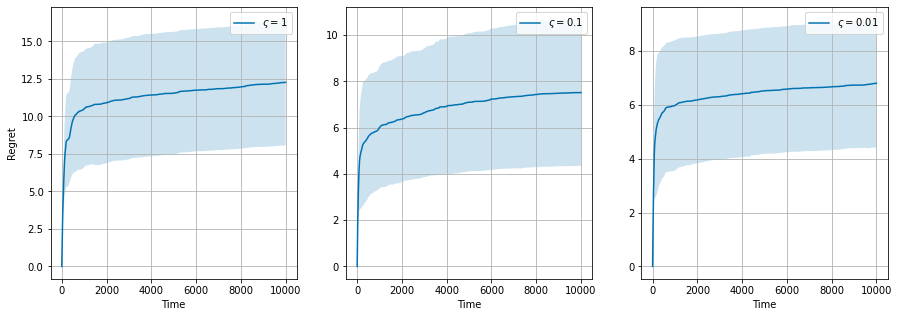

In [9]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
linestyles = ['-', '--']
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0], linestyles[0], label=r"$\varsigma=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0]-std_regrets_over_all_runs_dist_kl_ucb[0], mean_regrets_over_all_runs_dist_kl_ucb[0]+std_regrets_over_all_runs_dist_kl_ucb[0],alpha=.2)
ax1.legend()
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("Regret")

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1], linestyles[0], label=r"$\varsigma=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1]-std_regrets_over_all_runs_dist_kl_ucb[1], mean_regrets_over_all_runs_dist_kl_ucb[1]+std_regrets_over_all_runs_dist_kl_ucb[1],alpha=.2)
ax2.legend()
ax2.grid()
ax2.set_xlabel("Time")

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2], linestyles[0], label=r"$\varsigma=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2]-std_regrets_over_all_runs_dist_kl_ucb[2], mean_regrets_over_all_runs_dist_kl_ucb[2]+std_regrets_over_all_runs_dist_kl_ucb[2],alpha=.2)
ax3.legend()
ax3.grid()
ax3.set_xlabel("Time")

#plt.savefig("dist_KL_vs_dist_UCB1_3subplots.pdf", bbox_inches='tight')

In [16]:
mean_regrets_dist_ucb1 = np.zeros((n_runs, len(sigmas), T))
cpus = os.cpu_count()
init_time = time.time()

pool = Pool() # no need to pass in cpus, does os.cpu_count() by default
jobs = list(range(n_runs))
job_size = max(n_runs // cpus, 1)
job_chunks = [(jobs[i:i + job_size], seeds, sigmas, T, N, distributions) for i in range(0, len(jobs), job_size)]
results = pool.starmap(worker_ucb1, job_chunks)
pool.close()
pool.join()
mean_regrets_dist_ucb1_unconcat = [result for result in results]
np.concatenate(mean_regrets_dist_ucb1_unconcat, out=mean_regrets_dist_ucb1)

end_run_t = time.time()

time_axis = list(range(T))
mean_regrets_over_all_runs_dist_ucb1 = np.mean(mean_regrets_dist_ucb1, axis=0)
std_regrets_over_all_runs_dist_ucb1 = np.std(mean_regrets_dist_ucb1, axis=0)
print(f'Total run time = {end_run_t - init_time}sec')

/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1.py:113: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1.py:113: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1.py:113: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1.py:113: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1.py:113: FutureWarning: adjacency_matrix will return a scipy.sparse array instead of a matrix in Networkx 3.0.
  A = nx.adjacency_matrix(self.G)
/home/mulle/vip-mab/code/KL_UCB/Dist_UCB1.py:113: FutureWarning: adjac

finished run 24 in 207.9492952823639sec
finished run 72 in 209.2185413837433sec
finished run 80 in 209.76541471481323sec
finished run 0 in 211.22660565376282sec
finished run 88 in 212.06486797332764sec
finished run 32 in 215.33470964431763sec
finished run 40 in 216.81907176971436sec
finished run 48 in 218.14360213279724sec
finished run 16 in 218.5046272277832sec
finished run 56 in 218.59695291519165sec
finished run 8 in 220.46994996070862sec
finished run 64 in 221.67861485481262sec
finished run 89 in 208.20210528373718sec
finished run 1 in 209.49715518951416sec
finished run 25 in 213.80695819854736sec
finished run 81 in 212.35043239593506sec
finished run 57 in 204.7991328239441sec
finished run 17 in 207.5886127948761sec
finished run 33 in 212.72357654571533sec
finished run 73 in 218.7594974040985sec
finished run 41 in 211.92463040351868sec
finished run 49 in 211.29945015907288sec
finished run 65 in 212.8007116317749sec
finished run 9 in 222.82907009124756sec
finished run 26 in 205.3099

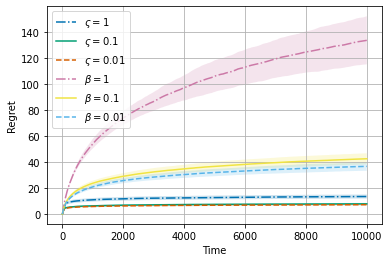

In [4]:
#linestyles = ['-.', '-', '--']
#for sig in range(len(sigmas)):
#    plt.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig], linestyles[sig], label=r"$\varsigma=$" + str(sigmas[sig]))
#    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[sig]-std_regrets_over_all_runs_dist_kl_ucb[sig], mean_regrets_over_all_runs_dist_kl_ucb[sig]+std_regrets_over_all_runs_dist_kl_ucb[sig],alpha=.2)
#for sig in range(len(sigmas)):    
#    plt.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[sig], linestyles[sig], label=r"$\beta=$" + str(sigmas[sig]))
#    plt.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[sig]-std_regrets_over_all_runs_dist_ucb1[sig], mean_regrets_over_all_runs_dist_ucb1[sig]+std_regrets_over_all_runs_dist_ucb1[sig],alpha=.2)
#plt.xlabel("Time")
#plt.ylabel("Regret")
#plt.legend()
#plt.grid()
#plt.savefig("dist_KL_vs_dist_UCB1.pdf", bbox_inches='tight')

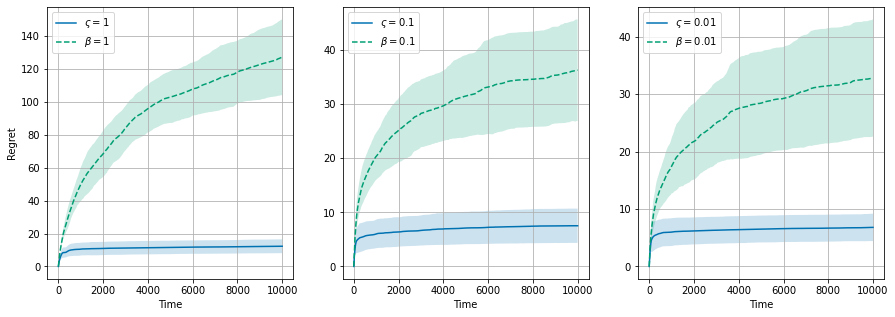

In [18]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,5))
linestyles = ['-', '--']
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0], linestyles[0], label=r"$\varsigma=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[0]-std_regrets_over_all_runs_dist_kl_ucb[0], mean_regrets_over_all_runs_dist_kl_ucb[0]+std_regrets_over_all_runs_dist_kl_ucb[0],alpha=.2)


ax2.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1], linestyles[0], label=r"$\varsigma=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[1]-std_regrets_over_all_runs_dist_kl_ucb[1], mean_regrets_over_all_runs_dist_kl_ucb[1]+std_regrets_over_all_runs_dist_kl_ucb[1],alpha=.2)

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2], linestyles[0], label=r"$\varsigma=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_kl_ucb[2]-std_regrets_over_all_runs_dist_kl_ucb[2], mean_regrets_over_all_runs_dist_kl_ucb[2]+std_regrets_over_all_runs_dist_kl_ucb[2],alpha=.2)


#plt.savefig("dist_KL_vs_dist_UCB1_3subplots.pdf", bbox_inches='tight')
ax1.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[0], linestyles[1], label=r"$\beta=$" + str(sigmas[0]))
ax1.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[0]-std_regrets_over_all_runs_dist_ucb1[0], mean_regrets_over_all_runs_dist_ucb1[0]+std_regrets_over_all_runs_dist_ucb1[0],alpha=.2)

ax2.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[1], linestyles[1], label=r"$\beta=$" + str(sigmas[1]))
ax2.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[1]-std_regrets_over_all_runs_dist_ucb1[1], mean_regrets_over_all_runs_dist_ucb1[1]+std_regrets_over_all_runs_dist_ucb1[1],alpha=.2)

ax3.plot(time_axis, mean_regrets_over_all_runs_dist_ucb1[2], linestyles[1], label=r"$\beta=$" + str(sigmas[2]))
ax3.fill_between(time_axis, mean_regrets_over_all_runs_dist_ucb1[2]-std_regrets_over_all_runs_dist_ucb1[2], mean_regrets_over_all_runs_dist_ucb1[2]+std_regrets_over_all_runs_dist_ucb1[2],alpha=.2)


ax1.legend(loc="upper left")
ax1.grid()
ax1.set_xlabel("Time")
ax1.set_ylabel("Regret")
ax2.legend(loc="upper left")
ax2.grid()
ax2.set_xlabel("Time")
ax3.legend(loc="upper left")
ax3.grid()
ax3.set_xlabel("Time")
plt.savefig("dist_KL_vs_dist_UCB1_3subplots_beta.pdf", bbox_inches='tight')